##Install dependencies!

In [0]:
%pip install -qq --upgrade notebook openai openpyxl pandas pydantic instructor matplotlib seaborn

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

## We're going to use an LLM to 'fuzzy-match' or structure data into defined categories. In this case we're going to look at relationships between university geography, "revenue"-per-student, and educational costs-per-student

We have a dataset from (collegescorecard.ed.gov)[https://collegescorecard.ed.gov/data ]. It contains lots of interesting stuff!

Today, we're going to pretend that you are working for a public sector client that has accumulated the following statistics:
- The institution's name
- Its admissions rate
- Average SAT scores
- Tuition revenue per student
- Cost of educating each student


### Goal
We want to quickly test a hypothesis:
Urban institutions have higher operating costs, and they pass these costs directly onto their students -- regardless of their federal funding

In [0]:
import asyncio
import instructor
import pandas as pd
import matplotlib.pyplot as plt

raw_df = pd.read_csv("3. Most-Recent-Cohorts-Institution.csv")

len(raw_df)

/root/.ipykernel/17423/command-4096868190359662-134278471:6: DtypeWarning: Columns (9,1407,1408,1431,1432,1532,1537,1538,1539,1540,1542,1546,1589,1601,1602,1606,1608,1611,1614,1615,1616,1619,1620,1621,1622,1623,1624,1625,1626,1627,1628,1629,1653,1679,1690,1692,1697,1700,1702,1725,1726,1727,1728,1729,1743,1815,1816,1817,1818,1823,1824,1830,1831,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1909,1910,1911,1912,1913,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1983,1984,2376,2377,2403,2404,2495,2496,2497,2498,2499,2500,2501,2502,2503,2504,2505,2506,2507,2508,2509,2510,2511,2512,2513,2514,2515,2516,2517,2518,2519,2520,2521,2522,2523,2524,2525,2526,2527,2528,2529,2530,2958,3215,3231,3235,3236) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv("3. Most-Recent-Cohorts-Institution.csv")


6429

### Here, we only take a small sample due to OpenAI limits on requests per minute

In [0]:
df = raw_df[[
    "INSTNM",    # name of institution
    "ADM_RATE",  # % of students admitted
    "SAT_AVG",   # Avg SAT score of admitted students
    "TUITFTE",   # Annual "revenue" per student
    "INEXPFTE",  # Annual educational costs per student
]].copy().sample(100)

df

,INSTNM,ADM_RATE,SAT_AVG,TUITFTE,INEXPFTE
1758,Blackfeet Community College,NaN,NaN,3735.0,15691.0
2504,Cuyahoga Valley Career Center,NaN,NaN,6962.0,11847.0
6309,Aviator College of Aeronautical Science & Tech...,NaN,NaN,NaN,NaN
4690,California Nurses Educational Institute,NaN,NaN,18809.0,9626.0
4534,Virginia Beach Theological Seminary,NaN,NaN,7383.0,18652.0
...,...,...,...,...,...
3259,Averett University,0.478,1054.0,15679.0,10409.0
6110,Columbia College - Hunter Army Airfield,NaN,NaN,NaN,NaN
5681,Valley College-Cleveland,NaN,NaN,9765.0,2049.0
2331,Wake Technical Community College,NaN,NaN,1893.0,6573.0


## Initial pass
Using seaborn, we can quickly estimate the relationship between costs and revenues (the slope of the linear regression).

However: **we don't have enough data to test our original hypothesis** since our dataset doesn't include information regarding the institution's geographies!

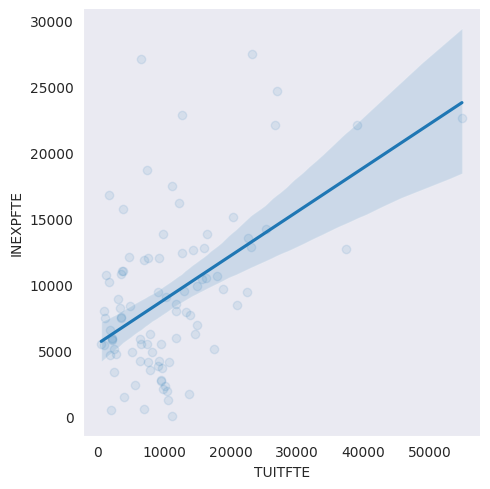

In [0]:
import seaborn as sns
sns.set_style("dark")

sns.lmplot(
    data=df.query("INEXPFTE < 200000"),
    x="TUITFTE",
    y="INEXPFTE",
    scatter_kws=dict(alpha=0.1),
);

plt.show()

---
## What do we do now?

We can use Structured Outputs in conjunction with Pydantic to quickly and easily define the additional data _we wish we had_, and use an LLM to quickly (ie fuzzily) impute the values!

In [0]:
from typing import Literal
from pydantic import BaseModel, Field

State = Literal[
    "AL",
    "AK",
    "AZ",
    "AR",
    "CA",
    "CO",
    "DE",
    "DC",
    "FL",
    "GA",
    "HI",
    "ID",
    "IL",
    "IN",
    "IA",
    "KS",
    "KY",
    "LA",
    "ME",
    "MD",
    "MA",
    "MI",
    "MN",
    "MS",
    "MO",
    "MT",
    "NE",
    "UT",
    "NH",
    "VT",
    "VA",
    "NY",
    "NC",
    "ND",
    "OH",
    "OK",
    "OR",
    "PA",
    "RI",
    "SC",
    "SD",
    "TN",
    "TX",
    "WA",
    "WV",
    "WY",
    "CT", 
    "NV", 
    "NJ", 
    "NM",
    "WI",
    "PR"
]

Geography = Literal["Urban", "Suburban", "Rural"]

class AdditionalFields(BaseModel):
    # The model actually gets to see this docstring! Treat it like a system prompt!
    """
    Fill in the additional information for each US-based educational institution.
    """
    state: State = Field(
        ## Same here with these `description` fields!
        description="The state that the institution is physically located in",
    )
    geography: Geography = Field(
        description="""
        Whether the institution is located in a rural, suburban, or urban geography. Definition:
        - Urban: more than 750 people per square mile
        - Suburban: Between 250-750 people per square mile
        - Rural: less than 250 people per square mile
        """,
    )

In [0]:
import openai
from openai import AsyncOpenAI

openai_base_url = "https://openai.prod.ai-gateway.quantumblack.com/ebbd1396-3006-4e05-b26e-e7bdcb680e62/v1"
openai_api_key = "eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJhZXNKN2kxNGNidnVuTU40MTJrOU5yZ2ROeENhTlJudTNPbC1TU08ycFlJIn0.eyJleHAiOjE3NTg2NjA3MzUsImlhdCI6MTc1ODY1ODkzNSwiYXV0aF90aW1lIjoxNzU4NjU4OTMxLCJqdGkiOiI0ODBkY2ViMy1jZjY5LTQyZTctYTAxOC1lZDU1YmJkNGU5NGIiLCJpc3MiOiJodHRwczovL2F1dGgubWNraW5zZXkuaWQvYXV0aC9yZWFsbXMvciIsImF1ZCI6ImJjZDIzNzI4LTNkMjctNDQ3Yy1hMGE5LWVhY2FmMzkzYTZmNSIsInN1YiI6IjkwMDJlMzJlLTY1NWItNDg2MS05YTZhLWNiYTIyZTYzZTI4NyIsInR5cCI6IklEIiwiYXpwIjoiYmNkMjM3MjgtM2QyNy00NDdjLWEwYTktZWFjYWYzOTNhNmY1Iiwic2Vzc2lvbl9zdGF0ZSI6IjRkODAyMWM4LWQ1YWMtNGY1Zi1hMDk1LTJhMzYzNzM2NDVlNCIsImF0X2hhc2giOiJOc2pPejFZak5RcElBT1dtWWs2dFZnIiwibmFtZSI6Ikx1Y8OtYSBWaWxsYWxvYm9zIiwiZ2l2ZW5fbmFtZSI6Ikx1Y8OtYSIsImZhbWlseV9uYW1lIjoiVmlsbGFsb2JvcyIsInByZWZlcnJlZF91c2VybmFtZSI6ImM4ODU5NmUxNTc1ZDIyMjMiLCJlbWFpbCI6Ikx1Y2lhX1ZpbGxhbG9ib3NAbWNraW5zZXkuY29tIiwiYWNyIjoiMSIsInNpZCI6IjRkODAyMWM4LWQ1YWMtNGY1Zi1hMDk1LTJhMzYzNzM2NDVlNCIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJmbW5vIjoiMzQxMDg0IiwiZ3JvdXBzIjpbIkFsbCBGaXJtIFVzZXJzIiwiNjYxYzBkZTAtZDI3Zi00ODlmLWE0ZDYtMTYxNmVlZTExMGVhIiwiZWJiZDEzOTYtMzAwNi00ZTA1LWIyNmUtZTdiZGNiNjgwZTYyIl19.hCUyCcta6IkA2Tw---tL1m5ykpRTtof4y7DYxj_d4KZXisihkX1A0l-hM27u3r94ttLfFlIybDmguUl3jBppqFgg3A5cep1oCbOfkJu-dZl_I0xsqeAeOP2JorW3kFPB0o3-w23ov4KuS3YPLf3B6wYQXYj0Fxm32UwO-EGcGSuj78Yt2OrFxAMgVM7qNEky9zLvDb6ZnQnwPzSt7TS51wZeGPIReuxnR0CPXIBU9XkbcHkEClDlvFEKEaQKlrYzCa-jcsjrOtyCpCr3m-OdpjR3GVthFBa17T53k65dQVQoDZUb-YZXSaLu4IlmpUB42_lNBseN-IWPMb7UEX-lLQ"


client = instructor.from_openai(AsyncOpenAI(api_key=openai_api_key, base_url=openai_base_url))

In [0]:
from textwrap import dedent

# Async function to call OpenAI API
async def augment_row(row):
    res = await client.chat.completions.create(
        model="gpt-4.1-nano",
        messages=[
            {
                "role": "system",
                "content": dedent("""
                    ## Instructions
                - Augment the given school data with the matching metadata
                - Accuracy is critical! 
                """)
            },
            {
                "role": "user",
                "content": f"School: {row['INSTNM']}"
            }
        ],
        response_model=AdditionalFields
    )
    return res 

print(df.iloc[1])
result = await augment_row(df.iloc[1])
print(result.state, result.geography)

INSTNM      Cuyahoga Valley Career Center
ADM_RATE                              NaN
SAT_AVG                               NaN
TUITFTE                            6962.0
INEXPFTE                          11847.0
Name: 2504, dtype: object
OH Suburban


Now we'll make use of `asyncio` to concurrently call OAI for each row in our dataset

In [0]:
# we already imported asyncio earlier 

additional_fields = await asyncio.gather(*[augment_row(row) for _, row in df.iterrows()])

### Let's augment our original dataframe to include these additional fields of "state" and "geography"

In [0]:
df["state"] = [field.state for field in additional_fields]
df["geography"] = [field.geography for field in additional_fields]

### Let's plot our findings!

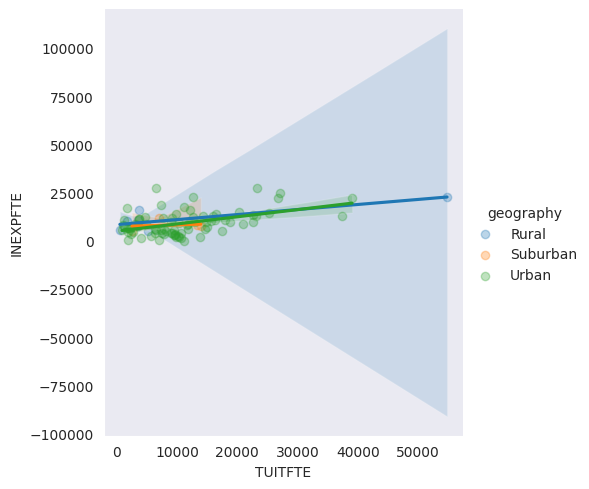

In [0]:
sns.lmplot(
    data=df.query("INEXPFTE < 200000"),
    x="TUITFTE",
    y="INEXPFTE",
    hue="geography",
    scatter_kws=dict(alpha=0.3),
);

plt.show()

## What does this graph tell us?
How might we explore further?

### Let's make a more detailed chart for each geography

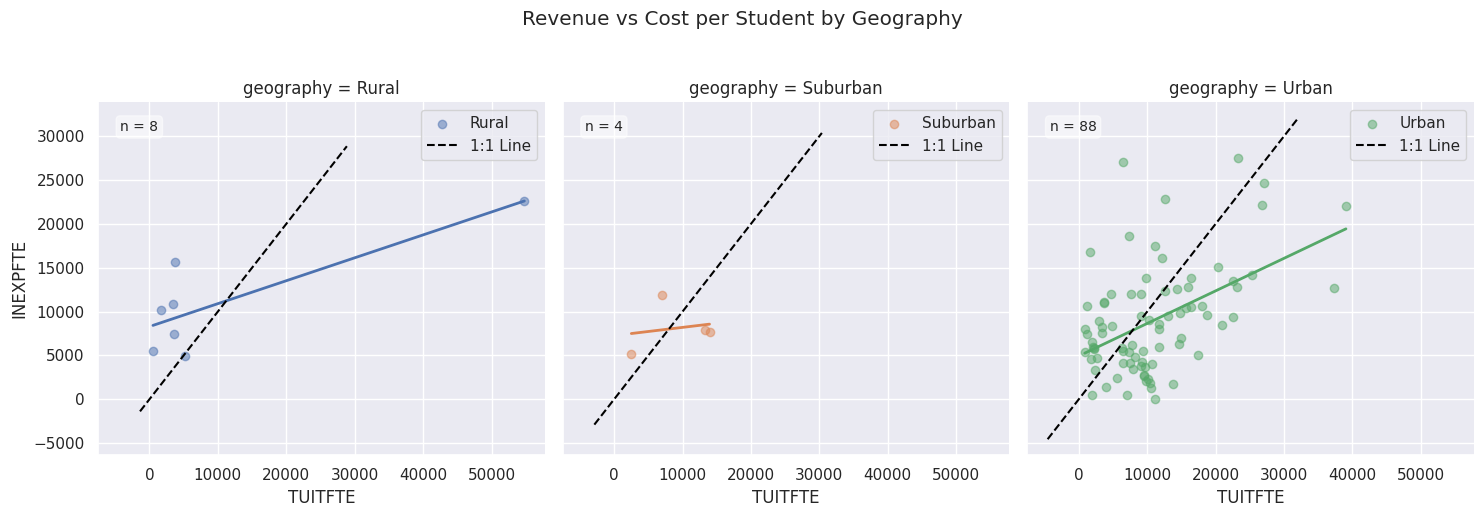

In [0]:
# Set plot style
sns.set(style="darkgrid")

# Regression plot by geography
sns.lmplot(
    data=df,
    x="TUITFTE",
    y="INEXPFTE",
    hue="geography",         # Different colours for Urban, Rural, Suburban
    col="geography",         # Separate subplots for comparison (optional)
    ci=None,                 # Remove confidence intervals for clarity
    scatter_kws={'alpha':0.5},
    line_kws={'linewidth':2}
)

# Count samples per Geography group
group_counts = df['geography'].value_counts().to_dict()

# Add 1:1 reference line to each plot
for ax in plt.gcf().axes:
    lims = [
        max(ax.get_xlim()[0], ax.get_ylim()[0]),
        min(ax.get_xlim()[1], ax.get_ylim()[1])
    ]
    ax.plot(lims, lims, '--', color='black', label='1:1 Line')
    ax.legend()

  # Extract geography name from plot title, and add sample size counter
    title = ax.get_title()
    for geo in group_counts:
        if geo in title:
            n = group_counts[geo]
            ax.text(
                0.05, 0.95, f"n = {n}",
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.5)
            )
            break

plt.suptitle("Revenue vs Cost per Student by Geography", y=1.03)
plt.tight_layout()
plt.show()